In [90]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from astropy.timeseries import LombScargle
import astropy.units as u
import matplotlib.pyplot as plt
import pickle
from astroquery.gaia import Gaia 
import math
from astropy.timeseries import BoxLeastSquares


In [3]:
query = """
SELECT source_id, frequency, global_ranking 
FROM gaiadr3.vari_eclipsing_binary 
WHERE source_id = '30259178472081408'

"""

job = Gaia.launch_job(query)
eclipsing_binaries = job.get_results().to_pandas("source_id")
eclipsing_binaries

,frequency,global_ranking
source_id,,
30259178472081408,1.110545,0.744218


In [4]:
datalink = Gaia.load_data(ids=eclipsing_binaries.index, 
                          data_release='Gaia DR3', 
                          retrieval_type='EPOCH_PHOTOMETRY', 
                          format='csv', 
                          valid_data=False)

type(datalink), len(datalink)

(dict, 1)

In [5]:
for key, value in datalink.items():
    break
print(key)
lc = value[0].to_pandas()
lc

EPOCH_PHOTOMETRY-Gaia DR3 30259178472081408.csv


,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,30259178472081408,17239323324331555,G,NaN,NaN,NaN,NaN,NaN,true,true,8373247,375316653866487564
1,30259178472081408,17243415621203420,G,1708.684396,11.594588,433622.099477,266.124300,1629.3969,false,false,4097,375316653866487564
2,30259178472081408,23732759071314360,G,1826.042416,11.821528,351832.331000,112.124659,3137.8677,false,false,1023,375316653866487564
3,30259178472081408,23736851385210311,G,1826.116443,11.754490,374240.453251,312.567410,1197.3112,false,false,5119,375316653866487564
4,30259178472081408,24594176600880402,G,1841.619397,11.577966,440312.020907,342.737197,1284.6929,false,false,1,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
64,30259178472081408,56296208830620090,RP,2414.932365,11.137475,278079.090369,246.946045,1126.0723,false,false,0,375316653866487564
65,30259178472081408,57784733786838029,RP,2441.854168,10.998784,315969.006482,278.419029,1134.8685,false,false,0,375316653866487564
66,30259178472081408,57788826063656081,RP,2441.928184,11.044480,302946.753942,260.640837,1162.3150,false,false,0,375316653866487564
67,30259178472081408,66599018331287929,RP,2601.253110,11.012270,312068.624030,267.692521,1165.7727,false,false,0,375316653866487564


In [6]:
sid = lc["source_id"].loc[0]

period_gaia = 1./eclipsing_binaries["frequency"].loc[sid]
period_gaia

0.9004589642295892

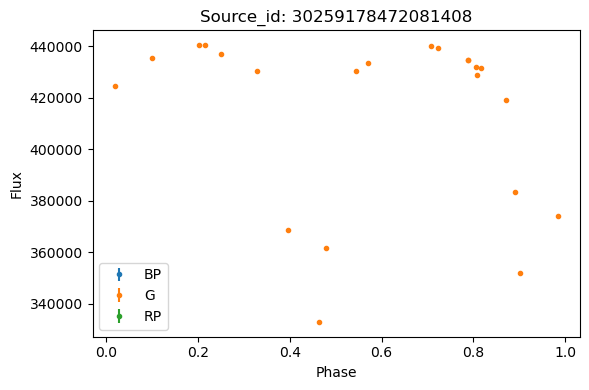

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

for name, data in lc.groupby("band"):
    mask = data["rejected_by_variability"]=="false"
    mask2 = lc["band"] == "G"
    mask3 = mask & mask2
    mjd, flux, flux_err = data.loc[mask3][['time', 'flux', 'flux_error']].values.T
    phase = np.mod(mjd, period_gaia)/period_gaia
    ax.errorbar(phase, flux, flux_err, fmt='.', label=name)
    
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')
ax.set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax.legend();

In [8]:
type_path = os.path.join("..","dataset","ECL")
#lc = pd.read_csv(os.path.join(type_path,"30259178472081408.csv"))
mask = lc["rejected_by_variability"] == "false"
mask2 = lc["band"] == "G"
mask3 = mask & mask2
mag,mjd = lc.loc[mask3][["mag","time"]].values.T
#frequency, power = LombScargle(mjd,mag).autopower()

In [9]:
type_path = os.path.join("..","dataset","ECL")
#lc = pd.read_csv(os.path.join(type_path,"30259178472081408.csv"))
mask = lc["rejected_by_variability"] == "false"
mask2 = lc["band"] == "G"
mask3 = mask & mask2
mag,mjd = lc.loc[mask3][["mag","time"]].values.T

mag_normalized = (mag - np.min(mag)) / (np.max(mag) - np.min(mag))

model_star = BoxLeastSquares(mjd * u.day, mag_normalized, dy=0.01)
periodogram_star = model_star.autopower(0.45)

peak_index = np.argmax(periodogram_star.power)
period = periodogram_star.period[peak_index]
period_box = period.value.astype(np.float64)
print(f"{period_box} - {period_gaia}")

0.9063722426406873 - 0.9004589642295892


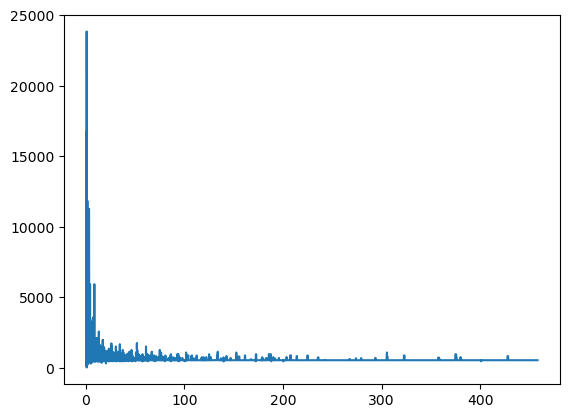

In [10]:
plt.plot(periodogram_star.period, periodogram_star.power)

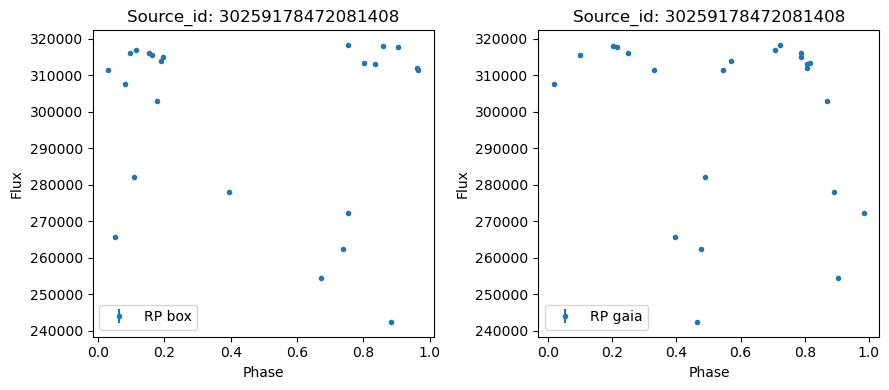

In [11]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True, nrows=1, ncols=2)


mask = data["rejected_by_variability"]=="false"
mask2 = lc["band"] == "G"
mask3 = mask & mask2

mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
phase = np.mod(mjd, period_box)/period_box
ax[0].errorbar(phase, flux, flux_err, fmt='.', label=f"{name} box")
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax[0].legend();

mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
phase = np.mod(mjd, period_gaia)/period_gaia
ax[1].errorbar(phase, flux, flux_err, fmt='.', label=f"{name} gaia")
    
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Flux')
ax[1].set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax[1].legend();

In [12]:
id = 245504251951140864

query = f""" select source_id,pf
            from gaiadr3.vari_rrlyrae
            where source_id = {id}
        """
job = Gaia.launch_job(query)
info_star_type = job.get_results().to_pandas("source_id")
info_star_type

,pf
source_id,
245504251951140864,0.507115


In [13]:
datalink = Gaia.load_data(ids=info_star_type.index, 
                          data_release='Gaia DR3', 
                          retrieval_type='EPOCH_PHOTOMETRY', 
                          format='csv', 
                          valid_data=False)

type(datalink), len(datalink)

(dict, 1)

In [14]:
for key, value in datalink.items():
    break
print(key)
lc = value[0].to_pandas()
lc.head()

EPOCH_PHOTOMETRY-Gaia DR3 245504251951140864.csv


,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,245504251951140864,17155095352861733,G,1707.085289,17.940062,1255.804716,15.501402,81.01233,false,false,1,375316653866487564
1,245504251951140864,19000765246218887,G,1740.466097,17.642814,1651.281993,9.798629,168.52174,false,false,1,375316653866487564
2,245504251951140864,19004857543091216,G,1740.540110,17.946054,1248.892935,8.174366,152.78163,false,false,1,375316653866487564
3,245504251951140864,24217909742683551,G,1834.816264,17.837210,1380.583565,8.647122,159.65817,false,false,4194305,375316653866487564
4,245504251951140864,24222002028267352,G,1834.890266,17.985516,1204.315935,9.152900,131.57753,false,false,4194305,375316653866487564


In [15]:
period_gaia = info_star_type["pf"]
period_gaia = period_gaia.iloc[0]

In [16]:
mask = lc["rejected_by_variability"] == "false"
mask2 = lc["band"] == "G"
mask3 = mask & mask2
mag,mjd = lc.loc[mask3][["mag","time"]].values.T

mag_normalized = (mag - np.min(mag)) / (np.max(mag) - np.min(mag))

model_star = BoxLeastSquares(mjd * u.day, mag_normalized, dy=0.01)
periodogram_star = model_star.autopower(0.2)

peak_index = np.argmax(periodogram_star.power)
period = periodogram_star.period[peak_index]
period_box = period.value.astype(np.float64)
print(f"{period_box} - {period_gaia}")

0.5071169834411283 - 0.5071152853230051


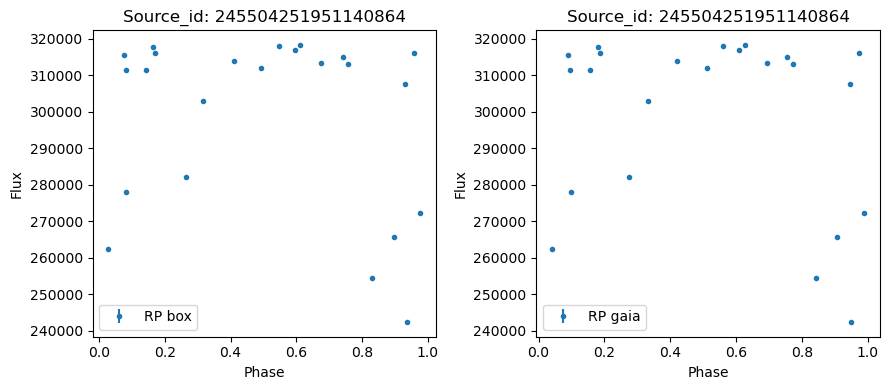

In [17]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True, nrows=1, ncols=2)


mask = data["rejected_by_variability"]=="false"
mask2 = lc["band"] == "G"
mask3 = mask & mask2

mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
phase = np.mod(mjd, period_box)/period_box
ax[0].errorbar(phase, flux, flux_err, fmt='.', label=f"{name} box")
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax[0].legend();

mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
phase = np.mod(mjd, period_gaia)/period_gaia
ax[1].errorbar(phase, flux, flux_err, fmt='.', label=f"{name} gaia")
    
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Flux')
ax[1].set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax[1].legend();


In [18]:
dataframe = pd.read_pickle('dataframe.pkl')

In [29]:
comparar = {"id":[], "value": [], "period_box":[], "period_gaia":[], "porcentaje": [], "tipo": []}

In [30]:
for dir in os.listdir("../dataset/"):
    for file in os.listdir(f"../dataset/{dir}")[:5]:
        df = pd.read_csv(f"../dataset/{dir}/{file}")
        mask = df["rejected_by_variability"]=="false"
        mask2 = df["rejected_by_variability"]== False
        mask3 = df["band"] == "G"
        mask4 = (mask | mask2) & mask3
        mag,mjd = df.loc[mask4][["mag","time"]].values.T
        id = int(file[:-4])
        period_gaia = dataframe.loc[id]["pf"]
        if not np.isnan(period_gaia):
            for value in np.arange(0.1, 1.0, 0.05):  
                model_star = BoxLeastSquares(mjd * u.day, mag, dy=0.01)
                periodogram_star = model_star.autopower(value)

                peak_index = np.argmax(periodogram_star.power)
                period = periodogram_star.period[peak_index]
                period_box = period.value.astype(np.float64)
                #print(f"{period_box} - {dataframe.loc[id]['pf']}")
                comparar["id"].append(id)
                comparar["value"].append(value)
                comparar["period_box"].append(period_box)
                comparar["period_gaia"].append(period_gaia)
                comparar["porcentaje"].append(abs(period_gaia - period_box)/period_gaia)
                comparar["tipo"].append(dir)
            print(f"Listo: ../dataset/{dir}/{file}")
        else:
            print(f"NaN ../dataset/{dir}/{file}")
df_error = pd.DataFrame(comparar)

Listo: ../dataset/ECL/3386015193828066304.csv
Listo: ../dataset/ECL/4053074016338568320.csv
Listo: ../dataset/ECL/5334492150703939968.csv
Listo: ../dataset/ECL/3050216710553407872.csv
Listo: ../dataset/ECL/199995018998593280.csv
Listo: ../dataset/CEP/5308137406706275840.csv
Listo: ../dataset/CEP/5940805262147383040.csv
Listo: ../dataset/CEP/5329713123372088320.csv
NaN ../dataset/CEP/4658087990487246464.csv
NaN ../dataset/CEP/4658968115135308288.csv
Listo: ../dataset/RR/4057431449654898944.csv
Listo: ../dataset/RR/5793037668215148544.csv
Listo: ../dataset/RR/5834119030492595712.csv
Listo: ../dataset/RR/2195648132814029312.csv
Listo: ../dataset/RR/2054039350212493568.csv


In [31]:
df_error

,id,value,period_box,period_gaia,porcentaje,tipo
0,3386015193828066304,0.10,0.240400,2.693795,0.910758,ECL
1,3386015193828066304,0.15,0.308575,2.693795,0.885450,ECL
2,3386015193828066304,0.20,0.407511,2.693795,0.848722,ECL
3,3386015193828066304,0.25,0.644899,2.693795,0.760599,ECL
4,3386015193828066304,0.30,0.644869,2.693795,0.760610,ECL
...,...,...,...,...,...,...
229,2054039350212493568,0.75,1.538335,0.583396,1.636861,RR
230,2054039350212493568,0.80,1.666264,0.583396,1.856144,RR
231,2054039350212493568,0.85,1.825355,0.583396,2.128841,RR
232,2054039350212493568,0.90,3.203880,0.583396,4.491771,RR


In [32]:
df_error.to_pickle('df_errores.pkl')


In [37]:
df_error[df_error["porcentaje"]<0.1]

,id,value,period_box,period_gaia,porcentaje,tipo
24,4053074016338568320,0.40,0.836515,0.850627,0.016589,ECL
146,4057431449654898944,0.20,0.535712,0.546448,0.019647,RR
147,4057431449654898944,0.25,0.501679,0.546448,0.081927,RR
162,5793037668215148544,0.10,0.515037,0.515040,0.000005,RR
163,5793037668215148544,0.15,0.515036,0.515040,0.000007,RR
164,5793037668215148544,0.20,0.515030,0.515040,0.000019,RR
165,5793037668215148544,0.25,0.515031,0.515040,0.000017,RR
182,5834119030492595712,0.20,0.407532,0.443746,0.081608,RR
198,2195648132814029312,0.10,0.501460,0.501487,0.000053,RR
199,2195648132814029312,0.15,0.501467,0.501487,0.000039,RR


In [39]:
df_error.set_index("id", inplace=True)

In [40]:
df_error.groupby("id")

(234, 5)

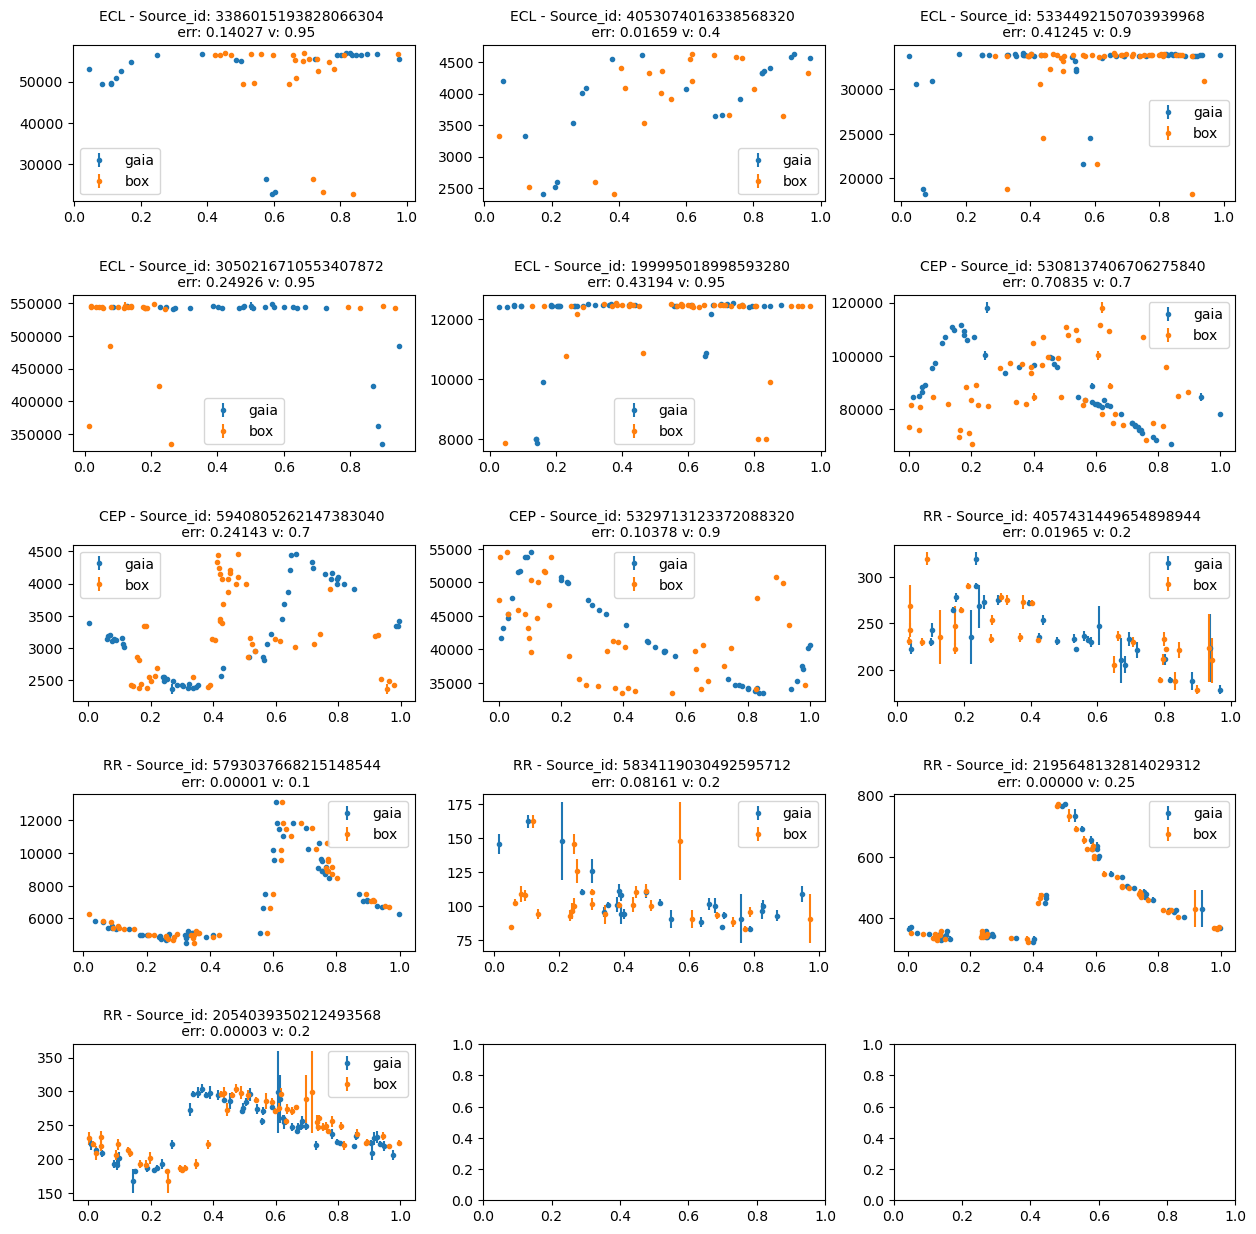

In [98]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,15))

for (n,id) in enumerate(df_error.index.unique()):
    sub_df = df_error.groupby("id").get_group(id)
    tipo = sub_df["tipo"].iloc[0]
    lc = pd.read_csv(f"../dataset/{tipo}/{id}.csv")
    mask = lc["rejected_by_variability"]=="false"
    mask2 = lc["rejected_by_variability"]== False
    mask3 = lc["band"] == "G"
    mask4 = (mask | mask2) & mask3


    mjd, flux, flux_err = lc.loc[mask4][['time', 'flux', 'flux_error']].values.T

    period_gaia = sub_df["period_gaia"].iloc[0]

    phase = np.mod(mjd, period_gaia)/period_gaia
    ax.flatten()[n].errorbar(phase, flux, flux_err, fmt='.', label=f"gaia")
    ax.flatten()[n].legend();

    min_error = min(sub_df["porcentaje"])
    #print(min_error)
    period_box = sub_df.loc[sub_df["porcentaje"] == min_error, "period_box"].iloc[0]
    valor = sub_df.loc[sub_df["porcentaje"] == min_error, "value"].iloc[0]
    #print(period_box)
    
    phase = np.mod(mjd, period_box)/period_box
    ax.flatten()[n].errorbar(phase, flux, flux_err, fmt='.', label=f"box")
    ax.flatten()[n].legend();

    ax.flatten()[n].set_title(f'{tipo} - Source_id: {lc["source_id"].loc[0]} \n err: {min_error:.5f} v: {round(valor, 4)}', fontsize=10)

plt.subplots_adjust(hspace=0.6, wspace=0.2)  

    
    